### FNO Library

In [ ]:
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial
import datetime
#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [ ]:
import math
import torch
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer


def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[int],
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)


class Adam(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    The implementation of the L2 penalty follows changes proposed in
    `Decoupled Weight Decay Regularization`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'])
        return loss

In [ ]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation 
discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
# from utilities3 import *

# from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(4, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

### Chemical Tubular Reactor (Data Generation)

In [ ]:
def lambda_ab(x, epsilon, alpha, beta):
#     print(np.cosh(alpha*x-beta))
    return (2*epsilon*alpha**2)/((np.cosh(alpha*x-beta))**2)

In [ ]:
num = 101
epsilon, alpha, beta = 1, 4, 2
x = np.linspace(0.0, 1.0, num= num)
lambda_ab_value = np.zeros(num, )

for i in range(num):
  lambda_ab_value[i] = lambda_ab(x[i], epsilon, alpha, beta)

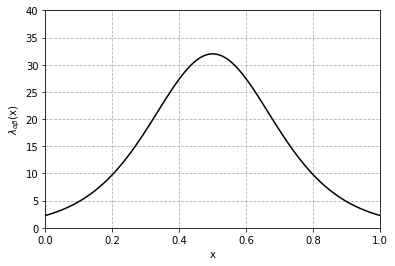

In [ ]:
plt.plot(x, lambda_ab_value, color = 'k')
plt.xlabel('x')
plt.ylabel('$\lambda_{\\alpha\\beta}$(x)')
plt.xlim([0, 1])
plt.ylim([0, 40])
plt.grid(linestyle='--')

# plt.savefig(
#     'lambda_func.eps'.format(index),
#     format='eps',
#     bbox_inches='tight')
# files.download('lambda_func.eps'.format(index)) 

In [ ]:
def p(x, epsilon, alpha, beta):
    return (epsilon*alpha**2*np.tanh(beta)*np.exp((1-x)*alpha*np.tanh(beta)))*(np.tanh(beta)-np.tanh(beta-alpha*x))

In [ ]:
def data_generation_observer(u0, u0_est, nx, max_iter_time):
    # plate size, mm
    L = 1.

    # intervals in x-, y- directions, mm
    dx = L/nx #0.01

    # Thermal diffusivity of steel, mm2.s-1
    epsilon = 1
    alpha = 4
    beta = 2

    Tcool, Thot = 0.0, 100.0

    dx2 = dx * dx

    dt = dx2/(4*epsilon)

    # print('dx', dx, 'dt', dt)
    gamma = (epsilon * dt) / dx2

    u = u0.copy()

    #Groundtruth system: FDM solver
    for t in range(0, max_iter_time, 1):
      for i in range(1, nx+1):
          x = i*dx
          lambda_x = lambda_ab(x, epsilon, alpha, beta)
          if(i < nx):
            u[t + 1, i] = u[t, i] + gamma * (u[t, i+1] + u[t, i-1] - 2*u[t, i]) + lambda_x*dt*u[t, i]
          else:
            u[t + 1, i] = u[t, i] + gamma * (u[t, i-1] + u[t, i-1] - 2*u[t, i]) + lambda_x*dt*u[t, i]

    
    #Observer: FDM solver
    u_hat = u0_est.copy()

    for t in range(0, max_iter_time, 1):
      for i in range(1, nx+1): #if x is not the boundary
          x = i*dx
          lambda_x = lambda_ab(x, epsilon, alpha, beta)
          p_x = p(x, epsilon, alpha, beta)
          if(i < nx):
            u_hat[t + 1, i] = (u_hat[t, i] + gamma * (u_hat[t, i+1] + u_hat[t, i-1] - 2*u_hat[t, i]) 
            + lambda_x*dt*u_hat[t, i] + p_x*dt*(u[t, nx]-u_hat[t, nx]))
          else:
            u_hat[t + 1, i] = (u_hat[t, i] + gamma * (u_hat[t, i-1] + u_hat[t, i-1] - 2*u_hat[t, i]) 
            + lambda_x*dt*u_hat[t, i] + p_x*dt*(u[t, nx]-u_hat[t, nx]))
        
    #return u_hat[-1, :], u[-1, :], u[:, nx]
    return u_hat, u, u[:, nx]

In [ ]:
num = 1200
n_train = 1024
n_test = 200
nx = 100
max_iter_time = 5000

In [ ]:
obs_data = torch.zeros((num, max_iter_time+1, nx+1))
sys_data = torch.zeros((num, max_iter_time+1, nx+1))
boundary_data = torch.zeros((num, max_iter_time+1, 1))

# Boundary conditions (fixed temperature)
u_left = 0.0
mu, sigma = 30, 10

for i in range(num):
  if(i%10 == 0):
    print('Generating ', i, 'Data Points!')
  
  # Initialize the true system
  u0 = np.zeros((max_iter_time+1, nx+1))
  #Thot = np.random.uniform(0, 100)
  #u0 = Thot*np.ones((max_iter_time+1, nx+1))
  #np.random.normal(mu, sigma, (max_iter_time+1, nx+1)) #np.random.gaussian((max_iter_time+1, nx+1))
  
  ## Set the boundary conditions
  u0[:, 0] = u_left

  ## Set the initial condition
  if(i%2 == 1): #even number index
    u0[0, :] = np.random.normal(mu, sigma, (1, nx+1))
  else: #odd number index
    x_array = np.linspace(0.0, 1.0, nx+1)
    scale = np.random.uniform(100, 200, 1)
    u0[0, :] = scale*np.sin(x_array*np.pi)

  # Initialize the observer
  Thot_est = 0.0 #np.random.uniform(0, 100)
  u0_est = Thot_est*np.ones((max_iter_time+1, nx+1))
  ## Set the boundary conditions
  u0_est[:, 0] = u_left

  a = datetime.datetime.now()
  obs, sys, u1 = data_generation_observer(u0, u0_est, nx = int(nx), max_iter_time = max_iter_time)
  b = datetime.datetime.now()
  print(b-a)

  obs_data[i, :, :] =  torch.from_numpy(obs)
  sys_data[i, :, :] =  torch.from_numpy(sys)
  boundary_data[i, :, :] =  torch.from_numpy(u1.reshape((-1, 1)))
  # x_data[i, 0:nx+1] = torch.from_numpy(u0_est[0, :])
  # x_data[i, nx+1:nx+1+max_iter_time+1] = torch.from_numpy(u1)
  
  # y_data[i, :] = torch.from_numpy(obs_T)
  # sys_data[i, :] = torch.from_numpy(sys_T)


Generating  0 Data Points!
0:00:06.705615
0:00:06.615131
0:00:07.303473
0:00:06.693341
0:00:06.495961
0:00:06.530946
0:00:06.546890
0:00:06.565851
0:00:06.514879
0:00:06.500292
Generating  10 Data Points!
0:00:06.460688
0:00:06.409850
0:00:06.480689
0:00:06.581394
0:00:06.697587
0:00:06.586288
0:00:06.488728
0:00:06.537641
0:00:06.492094
0:00:06.543337
Generating  20 Data Points!
0:00:06.559894
0:00:06.480028
0:00:06.537793
0:00:06.470366
0:00:06.523443
0:00:06.457934
0:00:06.514946
0:00:06.525172
0:00:06.572509
0:00:06.531019
Generating  30 Data Points!
0:00:06.459953
0:00:06.453348
0:00:06.460608
0:00:06.526209
0:00:06.579996
0:00:06.595148
0:00:06.548573
0:00:06.552192
0:00:06.499240
0:00:06.588740
Generating  40 Data Points!
0:00:06.475359
0:00:06.478451
0:00:06.531728
0:00:06.431423
0:00:06.650755
0:00:06.512657
0:00:06.505255
0:00:06.512806
0:00:06.550827
0:00:06.918417
Generating  50 Data Points!
0:00:06.760864
0:00:06.473119
0:00:06.520277
0:00:06.523633
0:00:06.493349
0:00:06.

<Figure size 432x288 with 0 Axes>

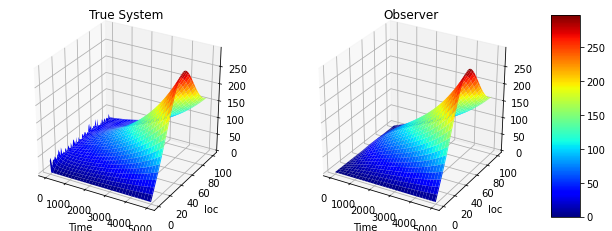

In [ ]:
f = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(sys[::50, :])

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, sys[::50, :].T, cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('loc')
ax[0].set_zlim([0, vmax])
ax[0].set_title('True System')
surf2 = ax[1].plot_surface(X, Y, obs[::50, :].T, cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('loc')
ax[1].set_zlim([0, vmax])
ax[1].set_title('Observer')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(surf1, shrink=0.5, cax=cbar_ax)
#fig.colorbar(surf1, shrink=0.5, aspect=5)

# plt.show()
# f.savefig('test1.eps', format='eps')

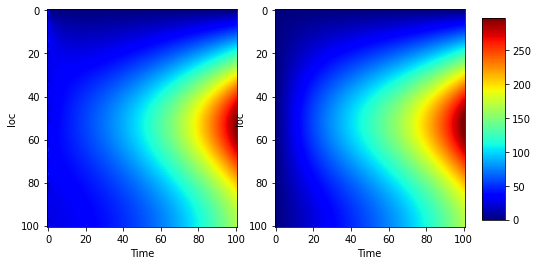

In [ ]:
vmax = np.max(sys)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.subplot(1, 2, 1)
im1 = plt.imshow(sys[::50, :].T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
plt.subplot(1, 2, 2)
im2 = plt.imshow(obs[::50, :].T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

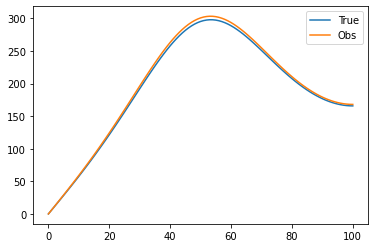

In [ ]:
plt.plot(sys[-1, :], label = 'True')

plt.plot(obs[-1, :], label = 'Obs')

plt.legend()

In [ ]:
sys[::50, :].shape

(101, 101)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# print('Save Data!')
# torch.save(obs_data, '/content/drive/My Drive/Colab Notebooks/data/heat_obs_data0218.pt')
# torch.save(sys_data, '/content/drive/My Drive/Colab Notebooks/data/heat_sys_data0218.pt')
# torch.save(boundary_data, '/content/drive/My Drive/Colab Notebooks/data/boundary_data0218.pt')

Save Data!


### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
################################################################
#  Load Data
################################################################
# obs_data = torch.load('/content/drive/My Drive/Colab Notebooks/data/heat_obs_data.pt')
# sys_data = torch.load('/content/drive/My Drive/Colab Notebooks/data/heat_sys_data.pt')
# boundary_data = torch.load('/content/drive/My Drive/Colab Notebooks/data/boundary_data.pt')
obs_data = torch.load('/content/drive/My Drive/Colab Notebooks/data/heat_obs_data0218.pt')
sys_data = torch.load('/content/drive/My Drive/Colab Notebooks/data/heat_sys_data0218.pt')
boundary_data = torch.load('/content/drive/My Drive/Colab Notebooks/data/boundary_data0218.pt')

In [ ]:
obs_data.shape

torch.Size([1200, 5001, 101])

In [ ]:
sys_data.shape

torch.Size([1200, 5001, 101])

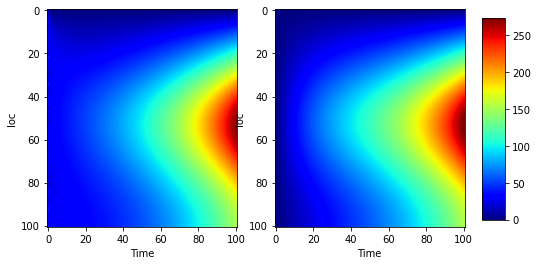

In [ ]:
index = 1
vmax = np.max(sys_data[index, ::50, :].detach().numpy())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.subplot(1, 2, 1)
im1 = plt.imshow(sys_data[index, ::50, :].detach().numpy().T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
plt.subplot(1, 2, 2)
im2 = plt.imshow(obs_data[index, ::50, :].detach().numpy().T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

<Figure size 432x288 with 0 Axes>

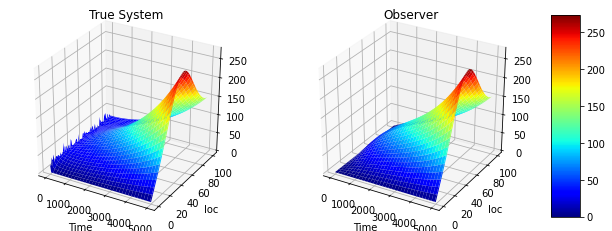

In [ ]:
bef = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(sys_data[index, ::50, :].detach().numpy())

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, sys_data[index, ::50, :].detach().numpy().T, cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('loc')
ax[0].set_zlim([0, vmax])
ax[0].set_title('True System')
surf2 = ax[1].plot_surface(X, Y, obs_data[index, ::50, :].detach().numpy().T, cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('loc')
ax[1].set_zlim([0, vmax])
ax[1].set_title('Observer')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(surf1, shrink=0.5, cax=cbar_ax)

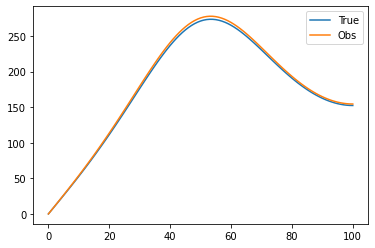

In [ ]:
plt.plot(sys_data[index, -1, :].detach().numpy(), label = 'True')

plt.plot(obs_data[index, -1, :].detach().numpy(), label = 'Obs')

plt.legend()

### Re-arrange data in the training/test data format

In [ ]:
num = 1200
n_train = 1000 
n_test = 100
nx = 100
max_iter_time = 5000

In [ ]:
### Reshape the data into training data: xdata [#, 101, T, 2], ydata [#, 101, T, 1]
### For xdata: we need to get the initial condition obs[i, 0, :] --> 

num = 1200
x_data = torch.zeros((num, nx+1, max_iter_time+1, 2))
y_data = torch.zeros((num, nx+1, max_iter_time+1, 1))
truey_data = torch.zeros((num, nx+1, max_iter_time+1, 1))

In [ ]:
for i in range(num):
  # initial condition 
  init_cond = obs_data[i, 0, :].reshape((-1, 1))
  init_cond = init_cond.repeat(1, max_iter_time+1)
  #print(init_cond.size())

  # boundary 
  u_boundary = boundary_data[i, :].reshape((1, -1))
  u_boundary = u_boundary.repeat(101, 1)
  #print(u_boundary.size())

  x_sample = torch.stack([init_cond, u_boundary], dim = -1)
  #print(x_sample.size() )

  x_data[i, :] = x_sample[:, :, :]

  ## observer output
  y_sample = torch.unsqueeze(obs_data[i].T, -1)
  #print(y_sample.size() )

  y_data[i, :] = y_sample[:, :, :]

  ## true system dynamics
  truey_sample = torch.unsqueeze(sys_data[i].T, -1)
  #print(truey_sample.size() )

  truey_data[i, :] = truey_sample[:, :, :]

### Downsample to T = 101, NX = 101

In [ ]:
### Reshape the data into training data: xdata [#, 101, T, 2], ydata [#, 101, T, 1]
### For xdata: we need to get the initial condition obs[i, 0, :] --> 
x_data2 = torch.zeros((num, nx+1, max_iter_time//50+1, 2))
y_data2 = torch.zeros((num, nx+1, max_iter_time//50+1, 1))
truey_data2 = torch.zeros((num, nx+1, max_iter_time//50+1, 1))

In [ ]:
x_data2 = x_data[:, :, ::50, :]
y_data2 = y_data[:, :, ::50, :]
truey_data2 = truey_data[:, :, ::50, :]

In [ ]:
y_data2.shape

torch.Size([1200, 101, 101, 1])

<Figure size 432x288 with 0 Axes>

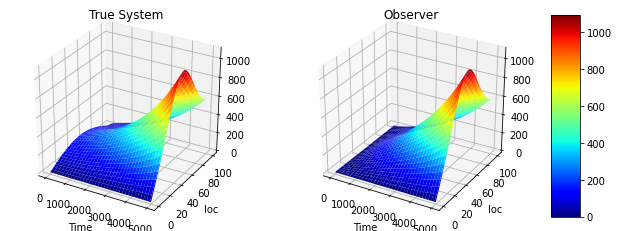

In [ ]:
index = 1004
f = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_data2[index, ::50, :].detach().numpy())

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, truey_data2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('loc')
ax[0].set_zlim([0, vmax])
ax[0].set_title('True System')
surf2 = ax[1].plot_surface(X, Y, y_data2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('loc')
ax[1].set_zlim([0, vmax])
ax[1].set_title('Observer')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(surf1, shrink=0.5, cax=cbar_ax)

### Train FNO for Observer

In [ ]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = nx+1 #h
T = max_iter_time//50+1
# T = max_iter_time+1

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

In [ ]:
x_train = x_data2[:ntrain,:]
y_train = y_data2[:ntrain,:]
x_test = x_data2[-ntest:,:]
y_test = y_data2[-ntest:,:]
truey_test = truey_data2[-ntest:,:]

x_train = x_train.reshape(ntrain, s, T, 2)
x_test = x_test.reshape(ntest, s, T, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [ ]:
x_test.shape

torch.Size([100, 101, 101, 2])

In [ ]:
y_train.shape

torch.Size([1000, 101, 101, 1])

In [ ]:
# model
model = FNO2d(modes, modes, width).cuda().cuda()
print(count_params(model))

2368033


In [ ]:
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    # model.eval()
    # test_l2 = 0.0
    # with torch.no_grad():
    #     for x, y in test_loader:
    #         x, y = x.cuda(), y.cuda()

    #         out = model(x)
    #         test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    # test_l2 /= ntest

    t2 = default_timer()
    #print(ep, t2-t1, train_mse, train_l2, test_l2)
    print(ep, t2-t1, train_mse, train_l2)

0 3.1693768709999404 26524.52490661621 0.46134538209438325
1 2.632784546000039 53.503178939819335 0.025256098359823228
2 2.643318206999993 14.866575121879578 0.013708085477352142
3 2.6390245730001425 15.132364912033081 0.013926121339201927
4 2.6506201409999903 11.506144180297852 0.0119677936732769
5 2.6500252379998983 10.008586871623994 0.011127540245652198
6 2.6390949799999817 9.095008289813995 0.010488517835736275
7 2.6428918730000532 8.758928680419922 0.010201250359416008
8 2.645263067000087 7.792262504100799 0.009870122835040093
9 2.6358246280001367 7.55907256603241 0.00969581238925457
10 2.6394298939999317 7.429125473499298 0.009514871187508106
11 2.6459040489999097 6.864439043998718 0.009350451067090034
12 2.6415022250000675 6.605990290641785 0.009227267429232598
13 2.6447393670000565 6.425023016929626 0.009059704713523388
14 2.643291137999995 6.360466117858887 0.009216118305921554
15 2.641933549999976 6.559977657794953 0.009030627489089966
16 2.645078852999859 6.2568182635307314

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/data/fno2d_obeserver0312')

### Test Model and Visualize Results

In [ ]:
model = FNO2d(modes, modes, width).cuda().cuda()
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/data/fno2d_obeserver0312'))

<All keys matched successfully>

In [ ]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size = 1, shuffle=False)
a = datetime.datetime.now()
test_mse = 0.0
batch_size = 1
index = 0
test_l2 = 0.0

with torch.no_grad():
    for x, y in test_loader:
        
        x, y = x.cuda(), y.cuda()

        out = model(x) #.view(-1)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')

        test_mse += mse.item()
        
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        #print(index, test_l2)
        index = index + 1
    
test_l2 /= len(test_loader)
print('Test L2', test_l2)
test_mse /= len(test_loader)
print('Test MSE', test_mse)
  
b = datetime.datetime.now()
print('Test on 100 data points', (b-a)/len(test_loader))

Test L2 0.0005684144888073206
Test MSE 0.010121084832353517
Test on 100 data points 0:00:00.004974


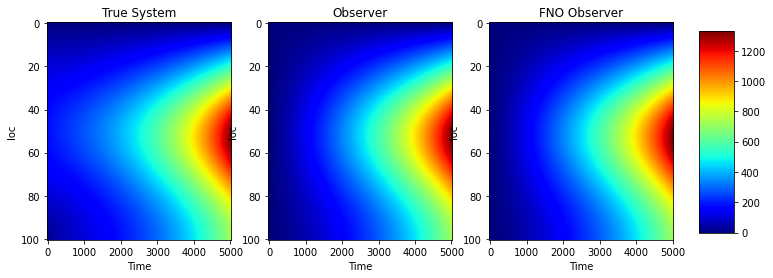

In [ ]:
index = 46
vmax = truey_test[index, :, :, 0].max()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(truey_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('True System')
plt.subplot(1, 3, 2)
im2 = plt.imshow(y_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('Observer')
plt.subplot(1, 3, 3)
im3 = plt.imshow(pred[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('FNO Observer')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im3, cax=cbar_ax)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

<Figure size 432x288 with 0 Axes>

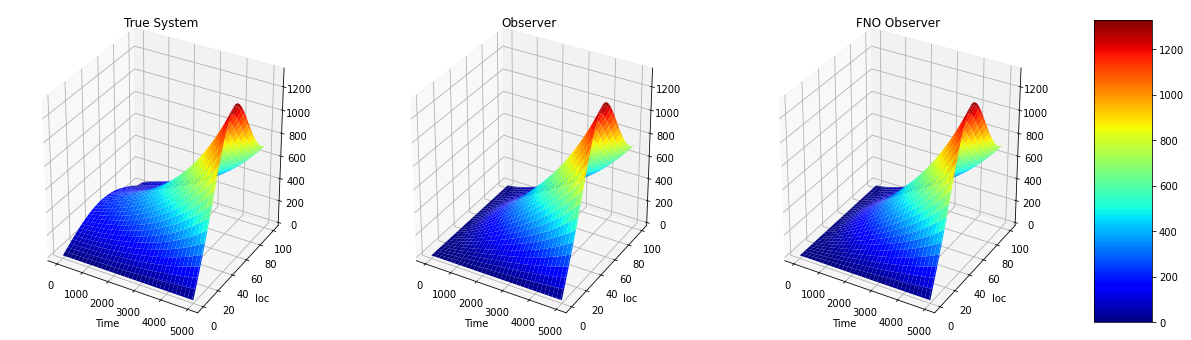

In [ ]:
index = 46

f = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, truey_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('loc')
ax[0].set_zlim([0, vmax])
ax[0].set_title('True System')
surf2 = ax[1].plot_surface(X, Y, y_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('loc')
ax[1].set_zlim([0, vmax])
ax[1].set_title('Observer')
surf3 = ax[2].plot_surface(X, Y, pred[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('loc')
ax[2].set_title('FNO Observer')
ax[2].set_zlim([0, vmax])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(surf1, shrink=0.5, cax=cbar_ax)
#fig.colorbar(surf1, shrink=0.5, aspect=5)

# plt.show()
# f.savefig('test1.eps', format='eps')

In [ ]:
from google.colab import files
files.download('test1.eps') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Make Plots (Backup)

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

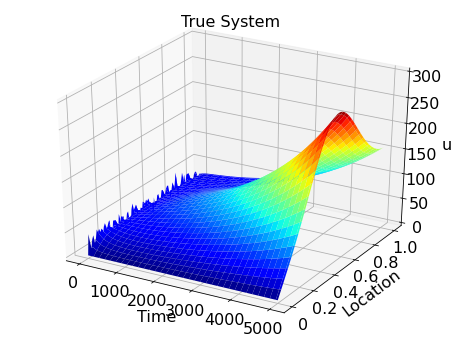

In [ ]:
index = 81
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, truey_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
# ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000]) # values
# ax.set_xticklabels([0, 0.025, 0.05, 0.075, 0.1, 0.125]) # labels
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('True System')
ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

from google.colab import files
plt.savefig(
    'truey_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('truey_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

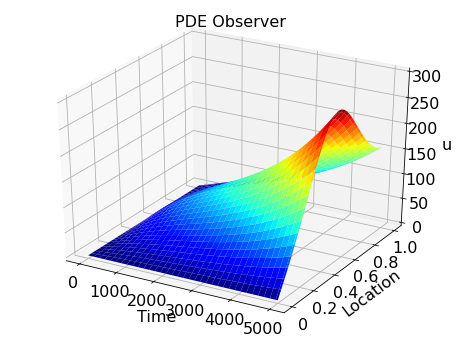

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

index = 81

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, y_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('PDE Observer')
ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('obs_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

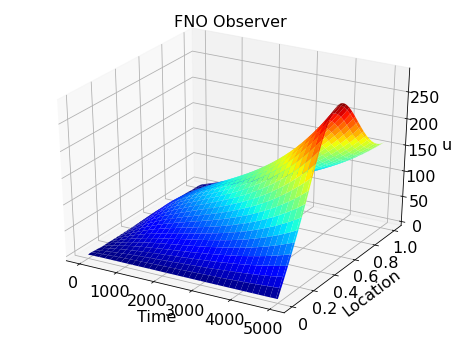

In [ ]:
index = 81

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, pred2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('FNO Observer')
# ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'fno_obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('fno_obs_text{}.eps'.format(index)) 

296.3208


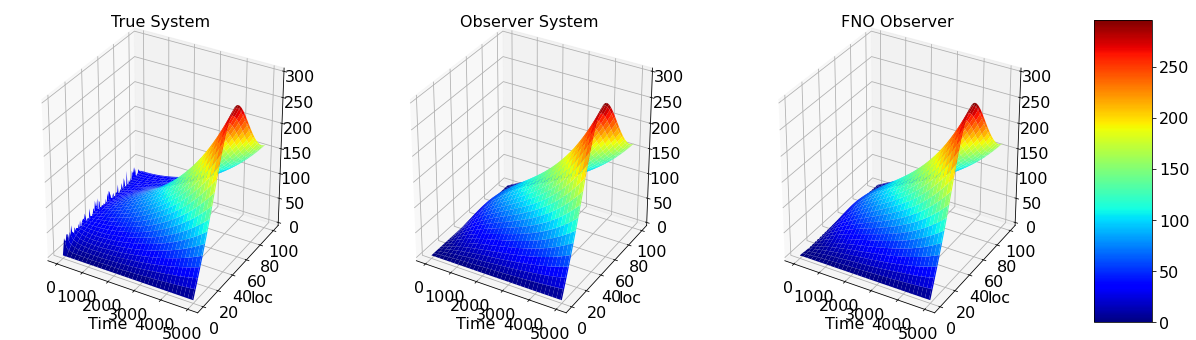

In [ ]:
index = 81

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())
print(vmax)

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, truey_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('loc')
ax[0].set_title('True System')
ax[0].set_zlim([0, 300])
surf2 = ax[1].plot_surface(X, Y, y_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('loc')
ax[1].set_zlim([0, 300])
ax[1].set_title('Observer System')
surf3 = ax[2].plot_surface(X, Y, pred2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('loc')
ax[2].set_zlim([0, 300])
ax[2].set_title('FNO Observer')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(surf1, shrink=0.5, cax=cbar_ax, aspect=5)
#fig.colorbar(surf1, shrink=0.5, aspect=5)

plt.show()

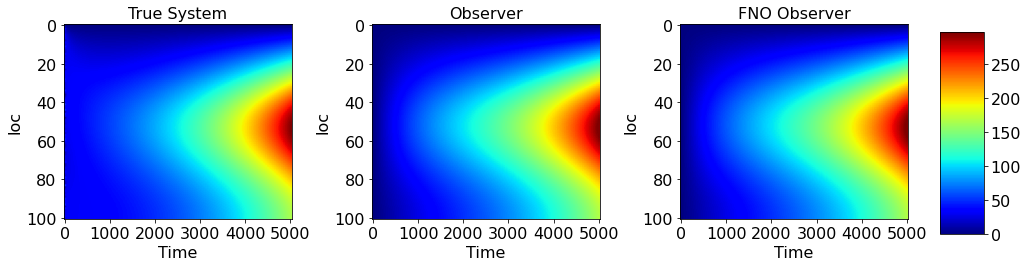

In [ ]:
index = 81
vmax = truey_test2[index, :, :, 0].max()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(truey_test2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('True System')
plt.subplot(1, 3, 2)
im2 = plt.imshow(y_test2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('Observer')
plt.tight_layout()
plt.subplot(1, 3, 3)
im3 = plt.imshow(pred2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('FNO Observer')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im3, cax=cbar_ax)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

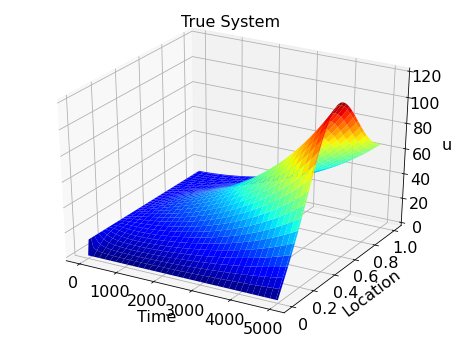

In [ ]:
index = 84

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, truey_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('True System')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'truey_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('truey_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

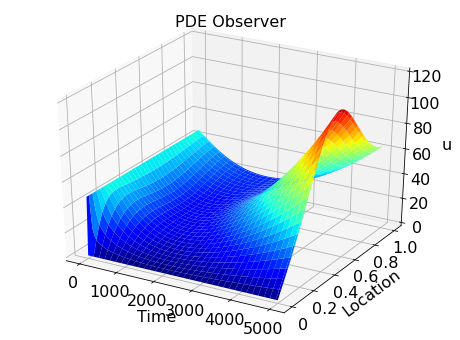

In [ ]:
index = 84

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, y_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('PDE Observer')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('obs_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

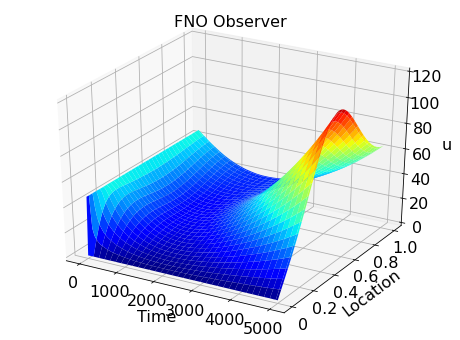

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, pred[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('FNO Observer')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'fno_obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('fno_obs_text{}.eps'.format(index)) 

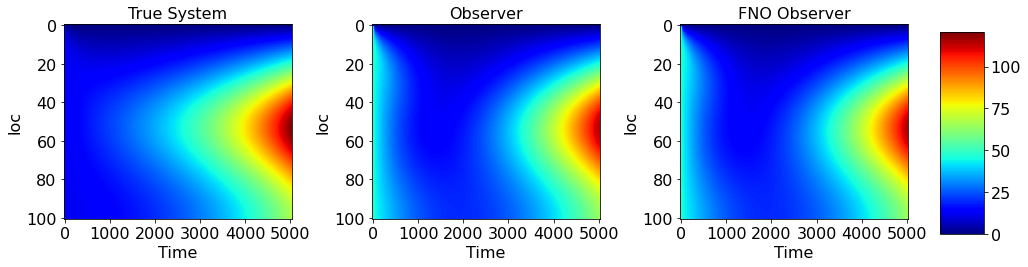

In [ ]:
index = 84
vmax = truey_test[index, :, :, 0].max()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(truey_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('True System')
plt.subplot(1, 3, 2)
im2 = plt.imshow(y_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('Observer')
plt.tight_layout()
plt.subplot(1, 3, 3)
im3 = plt.imshow(pred[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('FNO Observer')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im3, cax=cbar_ax)

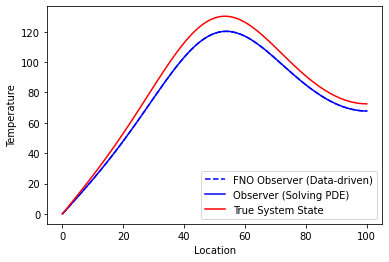

In [ ]:
plt.plot(pred[index, :, -1, 0], 'b--', label = 'FNO Observer (Data-driven)')
plt.plot(y_test[index, :, -1, 0], 'b', label = 'Observer (Solving PDE)')
plt.plot(truey_test[index, :, -1, 0], 'r', label = 'True System State')
plt.xlabel('Location')
plt.ylabel('Temperature')

plt.legend()